## STEP 0. 작업환경 구성하기

In [1]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow: ", tf.__version__)

tensorflow:  2.4.1


## STEP 1. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

### (1) `train_x`의 이미지를 -1, 1로 정규화

In [4]:
print("Before Normalization")
print("max pixel: ", train_x.max())
print("min pixel: ", train_x.min())

train_x = (train_x - 127.5) / 127.5
print("After Normalization")
print("max pixel: ", train_x.max())
print("min pixel: ", train_x.min())

Before Normalization
max pixel:  255
min pixel:  0
After Normalization
max pixel:  1.0
min pixel:  -1.0


In [5]:
train_x[0].dtype

dtype('float64')

### (2) 학습 데이터를 시각화를 통해 확인
Warning이 뜨지않게 원래 형태로 맞춰주고 시각화를 진행했습니다. 비슷하지만 다른 이슈가 생긴 부분을 참고할 수 있습니다.

[링크](https://github.com/matplotlib/matplotlib/issues/9391/)

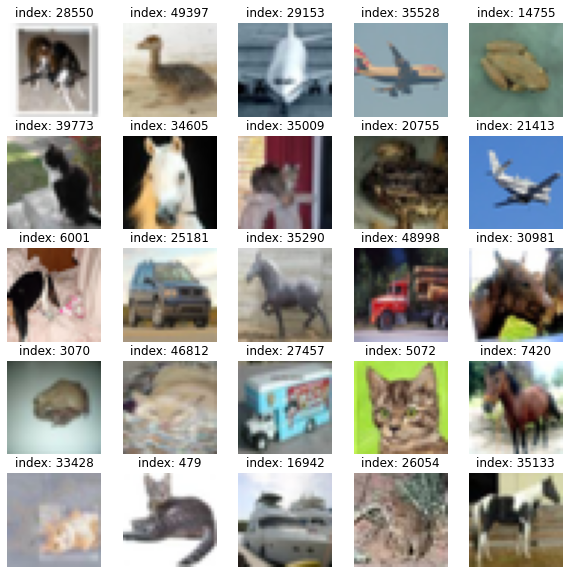

In [6]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=5, ncols=5)
axs = axes.ravel()

rng = np.random.default_rng()

for i in range(25):
    idx = rng.integers(0, 50000)
    axs[i].imshow(((train_x[idx] * 127.5) + 127.5).astype(np.uint8))

    axs[i].set_title(f"index: {idx}")
    axs[i].axis('off')

### (3) 미니배치 데이터셋 구성해보기
- [ ] tf.data.Dataset 모듈 공부

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

### (1) (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수

최종 Output의 Shape가 (32, 32, 3)이 되어야 하므로 (8, 8, 256)에서 출발하여 2배씩 늘려 (32, 32, 3)을 만들었습니다. 

In [9]:
def make_generator_model():
    # START
    model = tf.keras.Sequential()
    
    # FIRST: Dense Layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # SECOND: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # THIRD: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # FOURTH: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # FIFTH: Conv2DTranspose Layer

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     activation='tanh'))
    
    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
noise = tf.random.normal([1, 100])

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

기존의 방식과 비슷하게 시각화를 했지만 [32, 32, 3] 의 모양으로 만들고 위와 같이 warning이 뜨지않게 normalization을 풀어주고 자료형 변환을 cast로 했습니다.

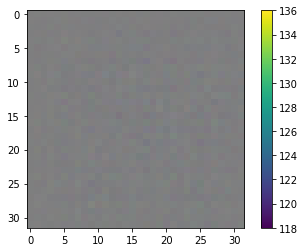

In [13]:
plt.imshow(tf.cast(generated_image[0, :, :, :] * 127.5 + 127.5, np.uint8))
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

### (1) 1dim의 판별결과를 출력하는 판별자 모델 구현 함수

입력을 (32, 32, 3)의 이미지를 받아 진짜인지 가짜인지 판별하기 위해 1dim 판별결과를 출력하도록 구현하겠습니다.

In [14]:
def make_discriminator_model():
    # START
    model = tf.keras.Sequential()
    
    # FIRST: Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # SECOND: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # THIRD: Flatten Layer
    model.add(layers.Flatten())
    
    # FOURTH: Dense Layer
    model.add(layers.Dense(1))
    
    return model

- [ ] 다양한 실험을 위해 subclass 해보기
- [ ] Flatten을 대체하는 globalaveragepooling 등을 쓴다면?

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00763599]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기

### (1) 생성자와 판별자의 손실함수 구현

cross_entropy는 마지막 레이어에 sigmoid가 없으므로 `from_logits=True`와 함께 정의해줍니다.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### (2) 판별자의 출력값으로 실제와 생성 이미지 판별 정확도를 계산하는 함수

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### (3) 생성자와 판별자를 최적화하는 optimizer 정의

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 5. 훈련과정 상세 기능 구현하기

### (1) 1개 미니배치의 훈련과정을 처리하는 `train_step()` 함수 구현

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

### (2) 훈련 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수 구현

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    prediction = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(6, 6))
    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(tf.cast(prediction[0, :, :, :] * 127.5 + 127.5, np.uint8))
        plt.axis('off')
        
        plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

        plt.show()

### (3) loss와 accuracy 히스토리를 시각화하는 `draw_train_history()` 함수 구현

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                .format(os.getenv('HOME'), epoch))
    plt.show()

### (4) `training_checkpoints` 디렉토리에 epoch 마다 모델을 저장하는 checkpoint 모듈 생성

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

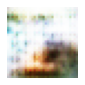

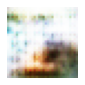

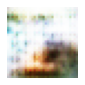

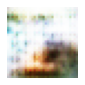

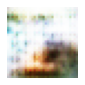

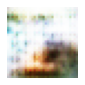

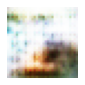

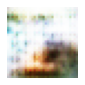

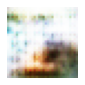

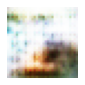

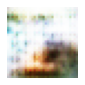

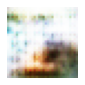

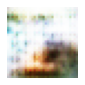

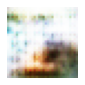

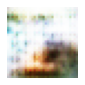

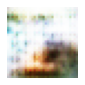

Time for training: 1557sec


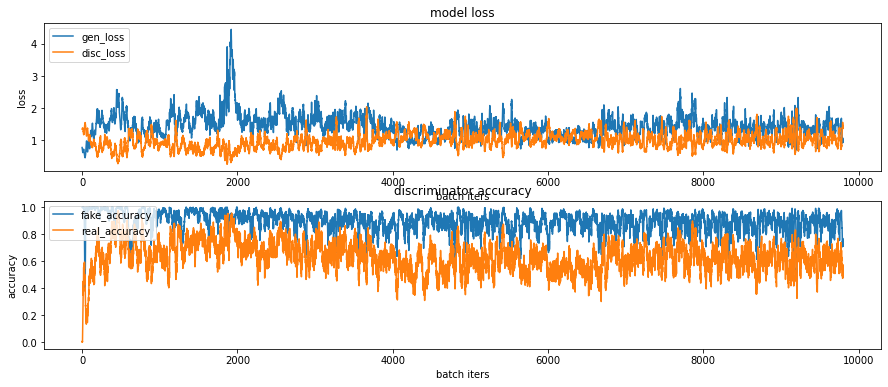

CPU times: user 25min 50s, sys: 35.2 s, total: 26min 25s
Wall time: 25min 58s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

1. 빨간색 스포츠카 같은 모습이 어렴풋하게 보이긴 하지만 확실히 판단하기 힘듭니다.


2. disc_loss와 gen_loss 모두 진동하며 줄어들지만 낮은 곳으로 수렴한다고 보기는 힘듭니다.
    
    
3. real_accuracy와 fake_accuracy 모두 0.5로 향하는 듯 하지만 분산이 커서 안정적이라고 보기 힘듭니다.

## checkpoint 사용해보기

checkpoint가 저장이 잘 됐는 지 확인해보기 위해 불러온 후 CIFAR-10 이미지를 그려보겠습니다.

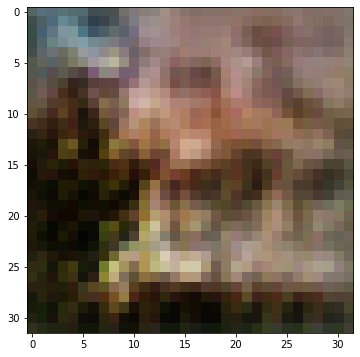

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

여전히 어떤 모습인지 알아보기 어렵습니다.

In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif

-rw-r--r-- 1 root root 790741 Sep  2 09:23 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif


In [32]:
### 움짤 만들고 나면 generated_samples 삭제
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

##  STEP 7. GAN 훈련 과정 개선하기

우선 노드에 참고로 제시된 페이지들을 보며 좋은 아이디어를 찾아보겠습니다. 이미 사용한 아이디어는 제외했습니다.
1. From [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
    1. generator loss를 `min(log (1-D))`에서 `max(log(D))` 꼴로 바꿔보기.
    2. generator 학습 시 라벨 바꾸기
    3. Label smoothing: Real=1 인 경우 0.7\~1.2, Fake=0 인 경우 0.1\~0.3으로 바꾸기
    4. Noisy Labels: discriminator에게 들어가는 라벨 바꾸기
    5. Experience Replay: 과거의 Replay buffer를 남겨두고 때때로 보여주기.
    6. Track failures early: 초반에 빨리 무너지는 지 체크하기: gradient의 norm 측정하기.
    
    
2. From [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
    1. 낮은 Learning rate를 사용해 mode collapsing을 피하기.
    2. 실제 data와 만들어진 data에 모두 noise를 더하기.
    3. Label smoothing
    4. Multi-Scale Gradient
    5. Two Time Scale Update Rule
    6. Spectral Normalization
    
    
3. From [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
    1. Feature matching: Develop a GAN using semi-supervised learning.
    2. Minibatch discrimination: Develop features across multiple samples in a minibatch.
    3. Historical averaging: Update the loss function to incorporate history.
    4. One-sided label smoothing: Scaling target values for the discriminator away from 1.0.
    5. Virtual batch normalization: Calculation of batch norm statistics using a reference batch of real images.
    
종합적으로 살펴보면 discriminator에 혼동을 줘서 학습을 어렵게 하는 방법이 많이 추천되고 있습니다. 모든 방법을 체크해볼 수는 없으니 이 중 몇개를 꼽아 하나씩 살펴보겠습니다.

### (1) 0.9 Label smoothing

Label smoothing을 진행하기 위해 `smooth_discriminator_loss`를 구현하고, 이를 `train_step`에 반영하며 수정을 진행해주겠습니다. generator와 discriminator의 구조는 별도로 수정하지 않겠습니다.

1. 0.9 label smoothing을 주기 위해서는 다음과 같이 구현할 수 있습니다.

`smoothed_target = tf.math.multiply(tf.cast(tf.ones_like(real_output), np.float32), 0.9)`

    1. 기존의 real_output의 크기만큼 1로 만들어진 tensor를 tf.cast를 이용해서 np.float32 자료형으로 바꿔줍니다.
    2. 1에서 구한 값에서 0.9를 곱해 [0.9, 0.9, ...] 꼴로 만들어줍니다.
---

2. Label smoothing을 [0.7, 1.2)의 값으로 구현할 수도 있습니다.

`lb = tf.subtract(tf.cast(tf.ones_like(real_output), np.float32) - 0.3)`

`ub = tf.random.uniform(real_output.shape) * 0.5`

`smoothed_target = lb + ub`

    1. lb는 [0.7, 0.7, ...] 꼴로 만들어지는 텐서입니다.
    2. ub는 real_output의 shape와 같은 [0, 1)의 난수를 만들어냅니다. 예를 들어 [0.2, 0, 0.9, ...]와 같은 값입니다. 여기다가 0.5를 곱합니다 그렇게 되면 ub는 [0, 0.5) 사이의 난수가 됩니다.
    3. 1과 2를 더해주면 [0.7, 1.2) 사이의 텐서가 만들어집니다.

---

3. 가장 간단하고 좋은 방법은 [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)에서 제공하고 있습니다!

`tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, axis=-1,
    reduction=losses_utils.ReductionV2.AUTO, name='binary_crossentropy'
)`

에서 label_smoothing 파라미터를 바꿔주면 됩니다. 0.1의 경우 true label이 0.9로 향한다고 생각할 수 있습니다.

In [33]:
def smooth_discriminator_loss(real_output, fake_output):
    smoothed_target = tf.math.multiply(tf.cast(tf.ones_like(real_output), np.float32), 0.9)
    real_loss = cross_entropy(smoothed_target, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [34]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = smooth_discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [35]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [36]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [37]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

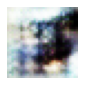

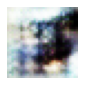

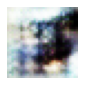

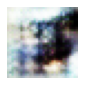

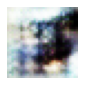

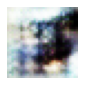

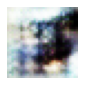

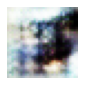

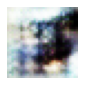

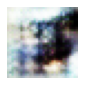

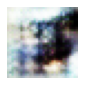

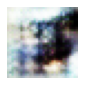

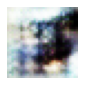

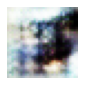

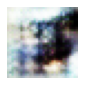

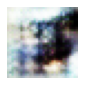

Time for training: 1548sec


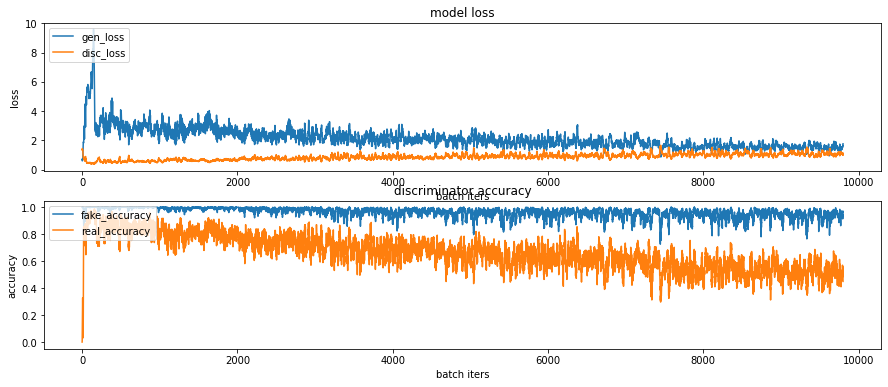

CPU times: user 25min 49s, sys: 29.7 s, total: 26min 19s
Wall time: 25min 49s


In [38]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

1. 커다란 덤프트럭이나 버스같은 모습이지만 확실이 판단하기 힘듭니다.


2. disc_loss가 너무 빨리 낮은 곳에서 시작합니다. Mode collapsing 일 수 있습니다.
    * 계속해서 같은 그림을 생성하는 것은 아닌 것 같아 Mode collapsing은 아닌 것 같습니다.
    
    
3. real_accuracy는 0.5를 향하는 반면에 fake_accuracy는 1 근처에 머물러 있습니다.

In [39]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing1.gif

-rw-r--r-- 1 root root 398360 Sep  2 09:49 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing1.gif


In [40]:
### 움짤 만들고 나면 generated_samples 삭제
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

### (2) [0.7, 1.2) Label smoothing

In [41]:
lb = tf.subtract(tf.cast(tf.ones_like([0.7, 0.7, 0.9, 0.8]), np.float32), 0.3)

ub = tf.random.uniform(lb.shape) * 0.5

smoothed_target = lb + ub

smoothed_target

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.76653785, 0.876449  , 0.97357917, 1.1498702 ], dtype=float32)>

In [42]:
def smooth_discriminator_loss(real_output, fake_output):
    
    lb = tf.subtract(tf.cast(tf.ones_like(real_output), np.float32), 0.3)
    ub = tf.random.uniform(real_output.shape) * 0.5
    smoothed_target = lb + ub
    
    real_loss = cross_entropy(smoothed_target, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [43]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = smooth_discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [44]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [45]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [46]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

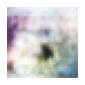

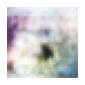

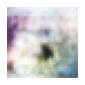

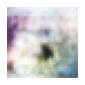

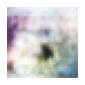

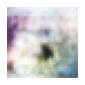

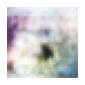

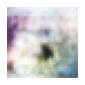

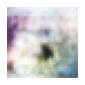

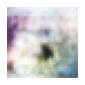

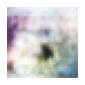

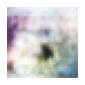

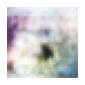

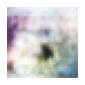

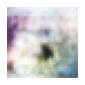

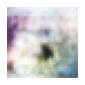

Time for training: 1541sec


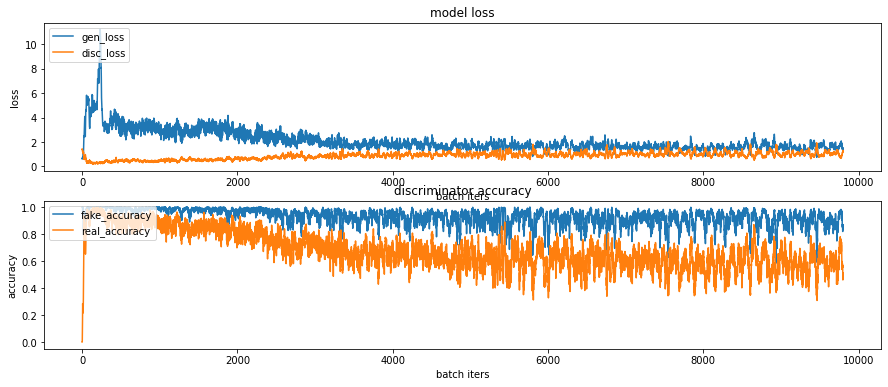

CPU times: user 25min 41s, sys: 29 s, total: 26min 10s
Wall time: 25min 42s


In [47]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

1. 무슨 이미지를 생성한 것인지 파악하기가 많이 힘듭니다.


2. disc_loss가 너무 빨리 낮은 곳에서 시작합니다.
    
    
3. real_accuracy는 0.5로 향하는 듯 하지만 분산이 커서 안정적이라고 보기 힘듭니다. fake_accuracy는 0.8에서 1사이에서 움직이는 모습입니다.

In [48]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing2.gif

-rw-r--r-- 1 root root 397403 Sep  2 10:15 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing2.gif


In [49]:
### 움짤 만들고 나면 generated_samples 삭제
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

### (3) Label smooting with TensorFlow

In [50]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.15)

In [51]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [52]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [53]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [54]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True) ## (BATCH_SIZE, 1)
        fake_output = discriminator(generated_images, training=True) ## (BATCH_SIZE, 1)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [55]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [56]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [57]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

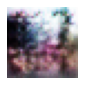

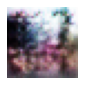

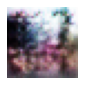

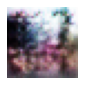

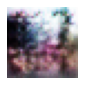

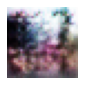

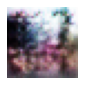

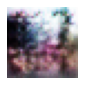

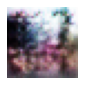

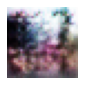

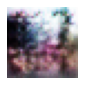

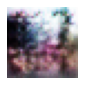

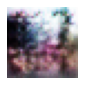

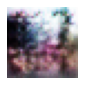

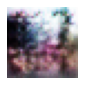

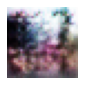

Time for training: 1541sec


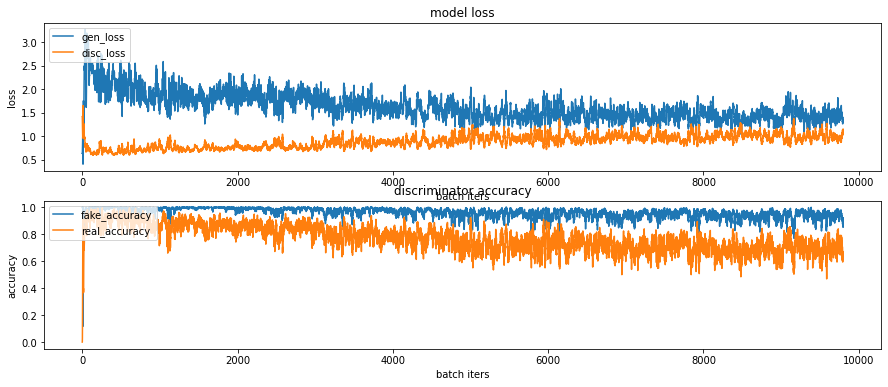

CPU times: user 25min 43s, sys: 29.7 s, total: 26min 12s
Wall time: 25min 42s


In [58]:
%%time
train(train_dataset, EPOCHS, save_every)

1. 무슨 이미지를 생성한 것인지 파악하기가 많이 힘듭니다.


2. gen_loss와 disc_loss 모두 낮은 곳으로 수렴하지 못하고 있습니다.
    
    
3. real_accuracy와 fake_accuracy 모두 높은 곳에 위치하고 있습니다.

In [59]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing3.gif

-rw-r--r-- 1 root root 399103 Sep  2 10:41 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing3.gif


In [60]:
### 움짤 만들고 나면 generated_samples 삭제
### 덮어쓰기 되서 필요없는듯
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

### (4) Batch size 줄여보기
배치사이즈가 너무 크면 학습과정에서 판별자가 너무 많은 샘플들을 보고 지나치게 똑똑해져 학습에 방해가 될 수 있다고 합니다. 배치사이즈를 64로 줄여 학습을 진행해보겠습니다. 

또한 앞으로 나올 모든 실험들은 배치사이즈를 64로 진행했습니다.

[Reference](https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5)

#### (a) BATCH_SIZE = 64 + 0.9 label smooting

In [61]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [63]:
def smooth_discriminator_loss(real_output, fake_output):
    smoothed_target = tf.math.multiply(tf.cast(tf.ones_like(real_output), np.float32), 0.9)
    real_loss = cross_entropy(smoothed_target, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [64]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = smooth_discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [65]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [66]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [67]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

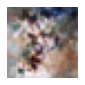

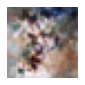

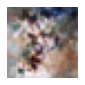

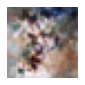

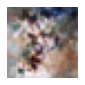

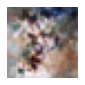

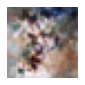

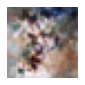

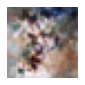

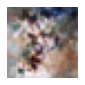

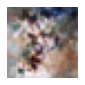

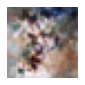

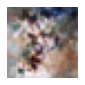

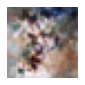

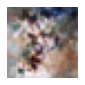

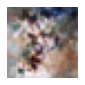

Time for training: 2633sec


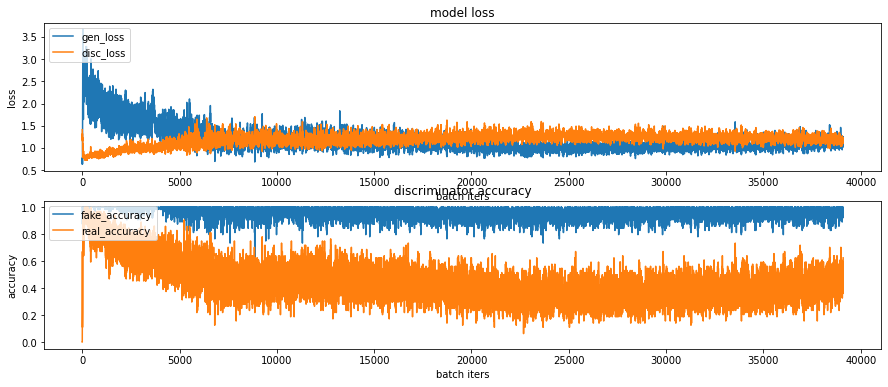

CPU times: user 22min 56s, sys: 1min 27s, total: 24min 24s
Wall time: 43min 55s


In [68]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

1. 강아지의 얼굴이 보이는 것 같기도 합니다만 무슨 이미지를 생성했는 지 분간이 힘들다고 보는 게 좋습니다.


2. disc_loss와 gen_loss 모두 낮은 곳으로 수렴하지 못합니다.
    
    
3. real_accuracy와 fake_accuracy 모두 분산이 커서 안정적이라고 보기 힘듭니다.

In [69]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing1_64batch.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing1_64batch

-rw-r--r-- 1 root root 786064 Sep  2 11:25 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing1.gif


In [70]:
### 움짤 만들고 나면 generated_samples 삭제
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

#### (b) BATCH_SIZE = 64 + 0.8 Label smooting with TensorFlow

In [141]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

In [142]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [143]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.15)

In [144]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [145]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [146]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [147]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True) ## (BATCH_SIZE, 1)
        fake_output = discriminator(generated_images, training=True) ## (BATCH_SIZE, 1)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [148]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [149]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [150]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

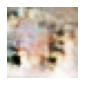

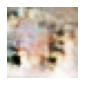

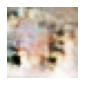

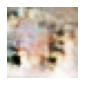

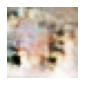

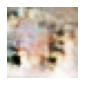

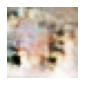

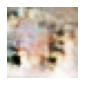

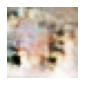

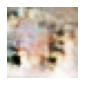

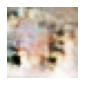

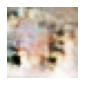

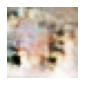

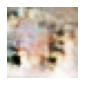

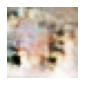

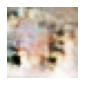

Time for training: 2628sec


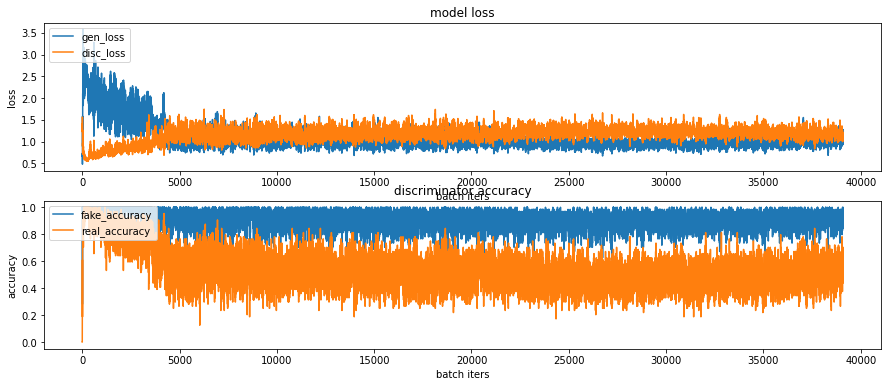

CPU times: user 22min 52s, sys: 1min 27s, total: 24min 19s
Wall time: 43min 50s


In [151]:
%%time
train(train_dataset, EPOCHS, save_every)

1. 무슨 이미지를 생성했는 지 분간이 힘들다고 보는 게 좋습니다. (학습 중에 강아지 얼굴이 거의 비슷하게 보였다가 학습이 끝나면서 사라졌습니다!)


2. disc_loss와 gen_loss 모두 낮은 곳으로 수렴하지 못합니다.
    
    
3. real_accuracy와 fake_accuracy 모두 분산이 커서 안정적이라고 보기 힘듭니다.

In [152]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing3_64batch.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing3_64batch.gif

-rw-r--r-- 1 root root 791464 Sep  2 14:44 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_smoothing3_64batch.gif


In [153]:
### 움짤 만들고 나면 generated_samples 삭제
### 덮어쓰기 되서 필요없는듯
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

### (4) BATCH_SIZE=64 + Noisy Labels: Flipping labels

라벨노이즈는 라벨을 뒤바꿔 노이즈를 주는 방식을 의미합니다. 판별자를 학습시킬 때 사용되는 라벨은 항상 맞는 라벨을 사용중입니다. 예를 들어 real_output과 비교를 할 때는 [1, 1, 1, 1, ...]을 사용하고 fake_output과 비교할 때는 [0, 0, 0, ..., 0]을 사용합니다. 이런 항상 맞는 라벨들 중 일부를 0으로 바꿔 판별자의 학습을 더욱 어렵게하고 Robustness를 올릴 수 있게 됩니다.

따라서 판별자에 들어가는 label에 노이즈가 있게 만들기 위해 `tf.random.categorical`을 사용했습니다. 크기는 각각의 output과 같게 했고 noisy_real_label의 경우 확률를 (0.05, 0.95)로 설정해 0이 5%, 1이 95%로 나오게 설정했습니다. noisy_fake_label의 경우 반대로 설정해줬습니다.

In [113]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [114]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [115]:
def discriminator_loss(real_output, fake_output):
    noisy_real_label = tf.random.categorical(tf.math.log([[0.05, 0.95]]), real_output.shape[0])
    noisy_real_label = tf.transpose(noisy_real_label)
    
    noisy_fake_label = tf.random.categorical(tf.math.log([[0.95, 0.05]]), fake_output.shape[0])
    noisy_fake_label = tf.transpose(noisy_fake_label)
    
    real_loss = cross_entropy(noisy_real_label, real_output)
    fake_loss = cross_entropy(noisy_fake_label, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [116]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [117]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True) ## (BATCH_SIZE, 1)
        fake_output = discriminator(generated_images, training=True) ## (BATCH_SIZE, 1)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [118]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [119]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [120]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

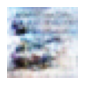

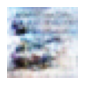

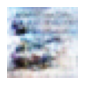

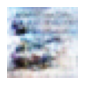

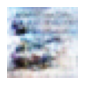

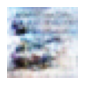

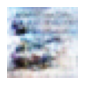

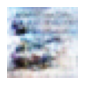

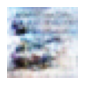

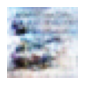

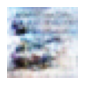

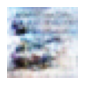

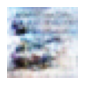

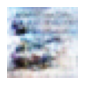

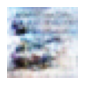

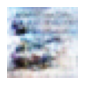

Time for training: 2641sec


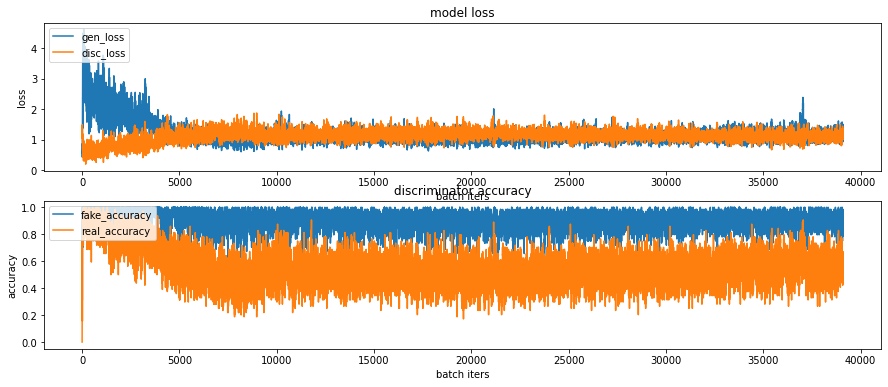

CPU times: user 22min 59s, sys: 1min 27s, total: 24min 27s
Wall time: 44min 3s


In [121]:
%%time
train(train_dataset, EPOCHS, save_every)

그래프로 확인해봤을 때는 마지막에는 real_accuracy, fake_accuracy 모두 0.6 ~ 0.8정도에 걸쳐서 움직이는 것 처럼 보입니다. 그림도 흐릿하지만 뭔가 자동차처럼 보이기도 합니다. 여기서 조금씩 발전시키는 방향으로 진행해보겠습니다.

1. 얼핏 자동차의 모습을 확인할 수 있습니다.


2. disc_loss와 gen_loss 모두 수렴하지만 아주 낮은 곳으로 수렴한다고 보기는 힘든 것 같습니다.
    
    
3. real_accuracy는 0.5로 향하는 듯 하지만 분산이 커서 안정적이라고 보기 힘듭니다. fake_accuracy는 0.8에서 1사이에서 움직이는 모습입니다.

In [122]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_noisy1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_noisy1.gif

-rw-r--r-- 1 root root 787611 Sep  2 12:19 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_noisy1.gif


In [123]:
### 움짤 만들고 나면 generated_samples 삭제
### 덮어쓰기 되서 필요없는듯
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

### (5) INPUT_NOISE_DIM = 128 + BATCH_SIZE=64 + Noisy Labels: Flipping labels
위에서 언급한 [Reference](https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5)에 따르면 Input noise에 dimension도 어느 정도 영향을 끼칠 수 있다고 합니다. 명확한 원인에 대한 설명이 없어 내키진 않지만 더 좋은 성능을 위해 한번 실험해보겠습니다.

생성자 모델의 구조와 train_step를 수정해야합니다.

In [170]:
def make_generator_model():
    # START
    model = tf.keras.Sequential()
    
    # FIRST: Dense Layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # SECOND: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # THIRD: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # FOURTH: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # FIFTH: Conv2DTranspose Layer

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     activation='tanh'))
    
    return model

In [171]:
generator = make_generator_model()

generator.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16384)             2097152   
_________________________________________________________________
batch_normalization_36 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_36 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 8, 8, 128)       

In [172]:
noise = tf.random.normal([1, 128])

In [173]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [174]:
discriminator = make_discriminator_model()

In [175]:
noise_dim = 128
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 128])

In [176]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [177]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [178]:
def discriminator_loss(real_output, fake_output):
    noisy_real_label = tf.random.categorical(tf.math.log([[0.05, 0.95]]), real_output.shape[0])
    noisy_real_label = tf.transpose(noisy_real_label)
    
    noisy_fake_label = tf.random.categorical(tf.math.log([[0.95, 0.05]]), fake_output.shape[0])
    noisy_fake_label = tf.transpose(noisy_fake_label)
    
    real_loss = cross_entropy(noisy_real_label, real_output)
    fake_loss = cross_entropy(noisy_fake_label, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [179]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [180]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True) ## (BATCH_SIZE, 1)
        fake_output = discriminator(generated_images, training=True) ## (BATCH_SIZE, 1)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [181]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f"Epoch {epoch+1} | iter {it+1}")
                print(f"Time for epoch {epoch+1}: {int(time.time()-epoch_start)} sec.")
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training: {int(time.time() - start)}sec")
        
        draw_train_history(history, epoch)

In [182]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

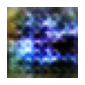

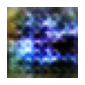

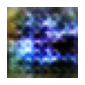

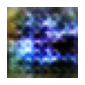

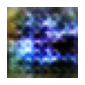

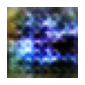

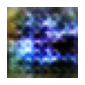

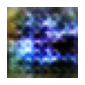

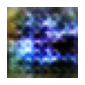

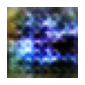

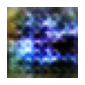

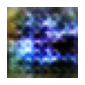

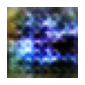

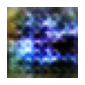

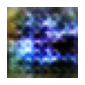

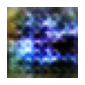

Time for training: 528sec


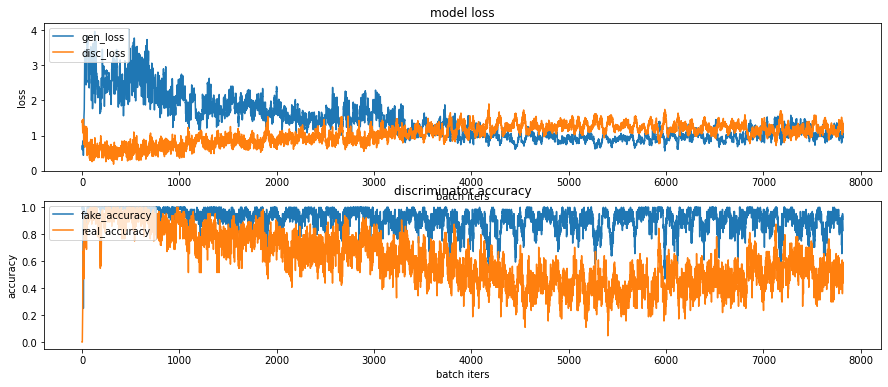

KeyboardInterrupt: 

In [183]:
%%time
train(train_dataset, EPOCHS, save_every)

In [184]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_noisy1_input128.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_dcgan_noisy1_input128.gif

-rw-r--r-- 1 root root 356871 Sep  2 14:56 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_dcgan_noisy1_input128.gif


In [185]:
### 움짤 만들고 나면 generated_samples 삭제
### 덮어쓰기 되서 필요없는듯
!rm /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/*.png

## 소감

최대한 기본적인 DCGAN의 모델 구조는 그대로 유지하며 batch_size, input_dim 그리고 다른 noisy label, label smoothing을 통해 문제를 해결해보려고 노력했습니다. 모델 구조를 바뀐다고 어떻게 학습의 양상이 바뀔 것인지 예상하는 것 보다는 batch_size나 label을 속이는 것은 학습을 어렵게 만든다는 이유가 있어서 이해할 수 있을 거라고 생각했습니다.

실제로는 다양한 일종의 regularizer를 사용했지만 그때마다 예상했던 것과 다른 결과가 나오는 경우도 많았고 무엇보다 안정적인 학습이 되지 않았던 것이 가장 아쉬웠습니다. 

역시 소문대로 GAN 학습시키는 건 너무 어려웠습니다. 조금 더 공부를 하고 이해를 해야할 것 같습니다. 안되는 이유라도 명확히 알면 좋을텐데 그 이유를 명확히 알지 못해 더욱 아쉽습니다.

학습 중에 무슨 이미지인지 분간이 갈 정도로 가까이 갔다가 멀어지기도 하고 아얘 모를 모습을 보이기도 했습니다. 다양한 실험을 위해 epoch을 50으로 제한해서 그런 것 같기도 합니다. 

노드는 제출했지만 계속해서 실험을 돌리며 알아볼 수 있을 때 까지 학습을 시켜보고 싶습니다.
